In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import cv2

In [90]:
ROOT_DIR = "data"
os.listdir(ROOT_DIR)

['Moderately-differentiate',
 'Normal',
 'Poorly-differentiate',
 'Well-differentiate']

In [91]:
len(os.listdir(ROOT_DIR))

4

In [92]:
# count the number of images in each class
number_of_images = {}

for image_class in os.listdir(ROOT_DIR):
    number_of_images[image_class] = len(os.listdir(os.path.join(ROOT_DIR, image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 180), ('Normal', 290), ('Poorly-differentiate', 261), ('Well-differentiate', 238)])

In [ ]:
# def countImages(path):
#     numbers_of_images = {}
#
#     for imageClass in os.listdir(path):
#         numbers_of_images[imageClass] = len(os.listdir(os.path.join(path, imageClass)))
#
#     print(numbers_of_images.items())

In [93]:
# Creating the train, validation and test folders
def dataFolder(p, split):
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)

        for imageClass in os.listdir(ROOT_DIR):
            os.makedirs("./" + p + "/" + imageClass)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, imageClass)),  #selecting images randomly
                                        size=(math.floor(split * number_of_images[imageClass]) - 5), replace=False):
                o = os.path.join(ROOT_DIR, imageClass, img)  #path
                d = os.path.join("./" + p, imageClass)
                shutil.copy(o, d)
                os.remove(o)
    else:
        print("the folder exist")

In [98]:
dataFolder("train", 0.7)

the folder exist


In [99]:
dataFolder("val", 0.15)

the folder exist


In [100]:
dataFolder("test", 0.15)

the folder exist


In [101]:
# count the number of images in each class
number_of_images = {}

for image_class in os.listdir('train'):
    number_of_images[image_class] = len(os.listdir(os.path.join('train', image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 120), ('Normal', 198), ('Poorly-differentiate', 177), ('Well-differentiate', 161)])

In [102]:
number_of_images = {}

for image_class in os.listdir(ROOT_DIR):
    number_of_images[image_class] = len(os.listdir(os.path.join(ROOT_DIR, image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 16), ('Normal', 16), ('Poorly-differentiate', 16), ('Well-differentiate', 17)])

## Data Augmentation

In [103]:
datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='reflect')

In [104]:
def dataAugmentation(image_folder):
    dataset = []

    my_images = os.listdir(image_folder)
    for i, image_name in enumerate(my_images):
        image = cv2.imread(image_folder + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((224, 224))
        dataset.append(np.array(image))

    x = np.array(dataset)

    i = 0
    for _ in datagen.flow(x, batch_size=32, save_to_dir=image_folder,
                          save_prefix='aug', save_format='jpg', shuffle=True):
        i += 1
        if i > 30:
            break

In [105]:
dataAugmentation('train/Normal/')

In [106]:
dataAugmentation('train/Well-differentiate/')

In [107]:
dataAugmentation('train/Poorly-differentiate/')

In [108]:
dataAugmentation('train/Moderately-differentiate/')

## Preparing the data

In [109]:
train_datagen = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1 / 255, horizontal_flip=True,)
train_images = train_datagen.flow_from_directory(directory='train', target_size=(224, 224),
                                                 batch_size=32, class_mode='categorical')

Found 4233 images belonging to 4 classes.


In [110]:
validation_datagen = ImageDataGenerator(rescale=1 / 255)
validation_images = validation_datagen.flow_from_directory(directory='val', target_size=(224, 224),
                                                           batch_size=32, class_mode='categorical')

Found 124 images belonging to 4 classes.


In [111]:
test_datagen = ImageDataGenerator(rescale=1 / 255)
test_images = test_datagen.flow_from_directory(directory='test', target_size=(224, 224),
                                               batch_size=32, class_mode='categorical')

Found 124 images belonging to 4 classes.


# Model Building

In [112]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LeakyReLU

In [113]:
# CNN model
learning_rate = 0.001
dropout_rate = 0.3
epochs = 30

optimizer = Adam(learning_rate=learning_rate)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(rate=dropout_rate))

model.add(Flatten())

model.add(Dense(units=256, activation=LeakyReLU(alpha=0.1)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(units=128, activation=LeakyReLU(alpha=0.1)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 109, 109, 64)    

In [114]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Adding Early stopping and Model Checkpoint

In [115]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [153]:
# early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=6, verbose=1, mode='auto')

# model checkpoint
mc = ModelCheckpoint(monitor="val_accuracy", filepath="models/best_model_8.h5", save_best_only=True, verbose=1, mode='auto')

cd = [es, mc]

# Model Training

In [154]:
hs = model.fit(train_images,
               epochs=epochs,
               verbose=1,
               validation_data=validation_images,
               callbacks=cd)

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.6227
Epoch 1: val_accuracy improved from -inf to 0.44355, saving model to models\best_model_8.h5
133/133 [==============================] - 323s 2s/step - loss: 0.9194 - accuracy: 0.6227 - val_loss: 2.0157 - val_accuracy: 0.4435
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.8768 - accuracy: 0.6312
Epoch 2: val_accuracy did not improve from 0.44355
133/133 [==============================] - 300s 2s/step - loss: 0.8768 - accuracy: 0.6312 - val_loss: 1.5445 - val_accuracy: 0.3871
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.6454
Epoch 3: val_accuracy improved from 0.44355 to 0.61290, saving model to models\best_model_8.h5
133/133 [==============================] - 307s 2s/step - loss: 0.8383 - accuracy: 0.6454 - val_loss: 1.1384 - val_accuracy: 0.6129
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.8251 -

In [155]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [122]:
h.values()

dict_values([[1.3408278226852417, 1.195517897605896, 1.0891175270080566, 1.040588617324829, 0.9929541349411011, 0.9500596523284912, 0.9166870713233948, 0.8781844973564148, 0.8436607122421265], [0.45050790905952454, 0.5024805068969727, 0.5544531345367432, 0.5561068058013916, 0.5797306895256042, 0.60004723072052, 0.6106780171394348, 0.6364280581474304, 0.6527285575866699], [2.510380983352661, 2.1505126953125, 1.2147520780563354, 1.2685949802398682, 1.296079158782959, 1.0677952766418457, 1.064073085784912, 1.2672263383865356, 2.004380464553833], [0.30645161867141724, 0.30645161867141724, 0.5322580933570862, 0.5, 0.49193549156188965, 0.5887096524238586, 0.5564516186714172, 0.524193525314331, 0.33870968222618103]])

<function matplotlib.pyplot.show(close=None, block=None)>

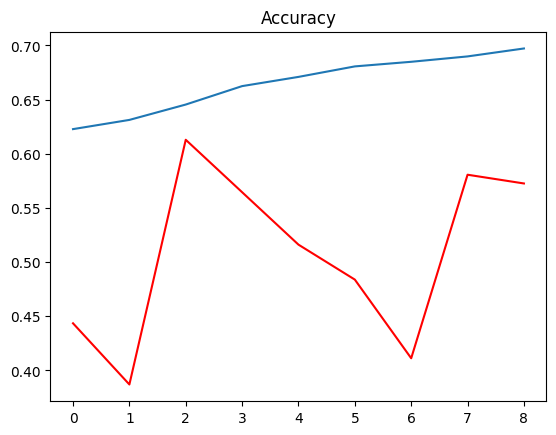

In [156]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title('Accuracy')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

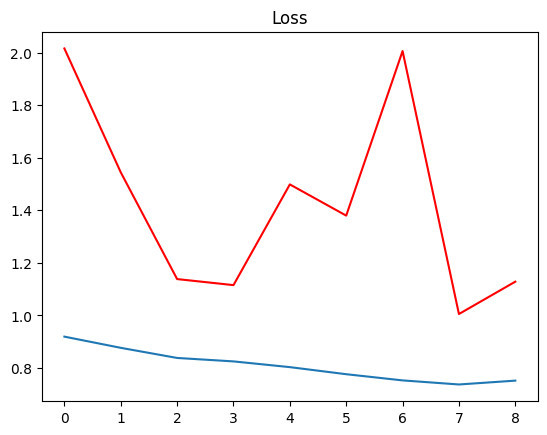

In [157]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")
plt.title('Loss')
plt.show

# Model Accuracy

In [158]:
from keras.models import load_model

model = load_model('models/best_model_8.h5')

In [159]:
acc = model.evaluate(test_images)[1]
print(f"the accuracy of the model is {acc*100} %")

4/4 [==============================] - 6s 1s/step - loss: 1.1081 - accuracy: 0.6048
the accuracy of the model is 60.48387289047241 %


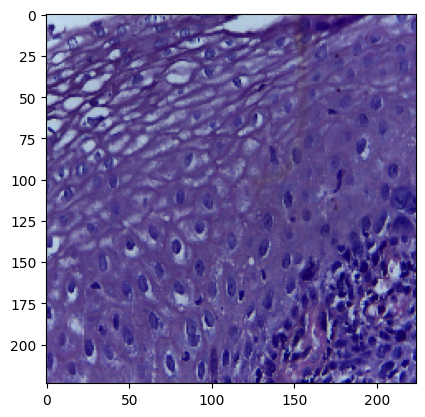

1/1 [==============================] - 0s 63ms/step
predicted class is Moderately-differentiate


In [162]:
path = "data/Moderately-differentiate/OSCC_400x_127.jpg"
img = load_img(path, target_size=(224, 224))
image = img_to_array(img)  # Convert image to numpy array
input_array = image / 255.0  # Normalize the image

plt.imshow(input_array)
plt.show()

input_array = np.expand_dims(input_array, axis=0)

pred = model.predict(input_array)[0]
pred_class = np.argmax(pred)

if pred_class == 0:
    print("predicted class is Moderately-differentiate")
elif pred_class == 1:
    print("predicted class is Normal")
elif pred_class == 2:
    print("predicted class is Poorly-differentiate")
elif pred_class == 3:
    print("predicted class is Well-differentiate")

In [128]:
train_images.class_indices

{'Moderately-differentiate': 0,
 'Normal': 1,
 'Poorly-differentiate': 2,
 'Well-differentiate': 3}